In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (20,8)

import statsmodels as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae, 
    mean_absolute_percentage_error as mape
    
)

# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3)) 
    print('MAPE:', round(mape(actual, predicted), 3))

In [3]:
df = pd.read_csv('exog.csv')
df.head()

,date,weekday,holiday,total
0,1/1/2016,Friday,1,296.0
1,1/2/2016,Saturday,0,191.0
2,1/3/2016,Sunday,0,202.0
3,1/4/2016,Monday,0,105.0
4,1/5/2016,Tuesday,0,98.0


In [4]:
df.shape

(517, 4)

In [5]:
df1 = df.copy()

In [6]:
df.isna().sum()

date        0
weekday     0
holiday     0
total      39
dtype: int64

In [7]:
df.dropna(inplace = True)

In [8]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date',inplace = True)
df.head(5)

,weekday,holiday,total
date,,,
2016-01-01,Friday,1,296.0
2016-01-02,Saturday,0,191.0
2016-01-03,Sunday,0,202.0
2016-01-04,Monday,0,105.0
2016-01-05,Tuesday,0,98.0


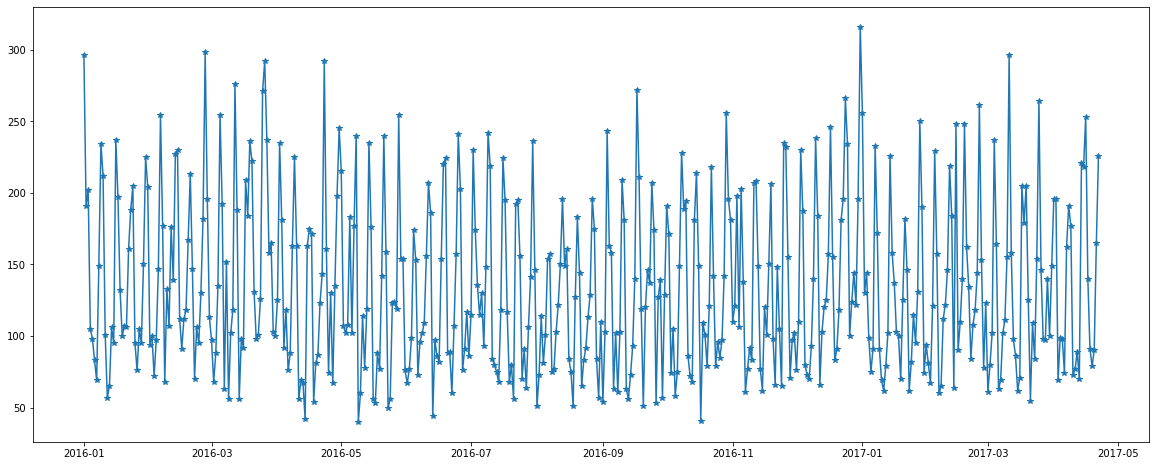

In [11]:
plt.plot(df.index, df['total'], '-*')
plt.show()

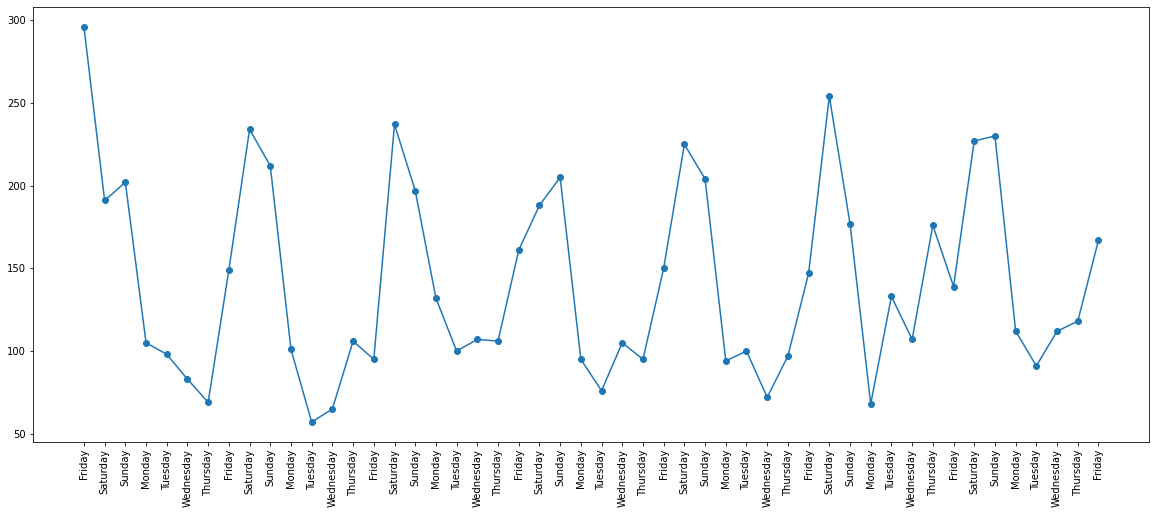

In [12]:
plt.plot(range(50),df['total'][:50], '-o')
plt.xticks(range(0,50), df['weekday'][:50],rotation = 90)
plt.show()

In [16]:
train = df.iloc[:436]
test = df.iloc[436:]

In [17]:
train.head()

,weekday,holiday,total
date,,,
2016-01-01,Friday,1,296.0
2016-01-02,Saturday,0,191.0
2016-01-03,Sunday,0,202.0
2016-01-04,Monday,0,105.0
2016-01-05,Tuesday,0,98.0


#### Without Exog

In [ ]:
order = (p,d,q)
seasonal_order = (1,0,1,7)

In [20]:
model = SARIMAX(train['total'], order=(1,0,0), seasonal_order=(1,0,1,7))  # a simple model
results = model.fit(disp=False)
fc = results.forecast(42)

In [27]:
# predictions with some in-samples
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end)

MAE : 25.159
RMSE : 31.97
MAPE: 0.202


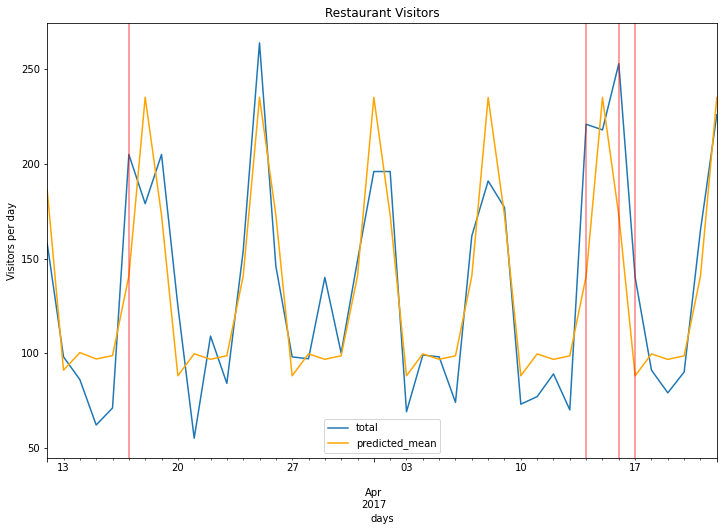

In [28]:
performance(test['total'], predictions)
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='days'
ax = test['total'].plot(legend=True,figsize=(12,8),title=title)
predictions.plot(legend=True,color = 'orange')

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='red', alpha = 0.5)

#### With Exog

In [30]:
model = SARIMAX(train['total'], exog=train['holiday'], order=(1,0,0),seasonal_order=(1,0,1,7))
results = model.fit(disp=False)

In [31]:
exog_forecast = test[['holiday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('Predictions')

MAE : 18.907
RMSE : 23.267
MAPE: 0.163


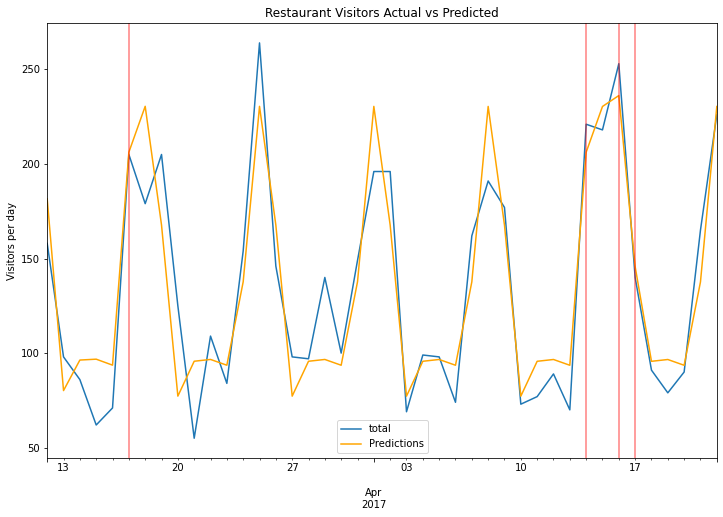

In [32]:
performance(test['total'], predictions)
# Plot predictions against known values
title='Restaurant Visitors Actual vs Predicted'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,8),title=title)
predictions.plot(legend=True, color = 'orange')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='red', alpha = 0.5);

## Confidence Interval

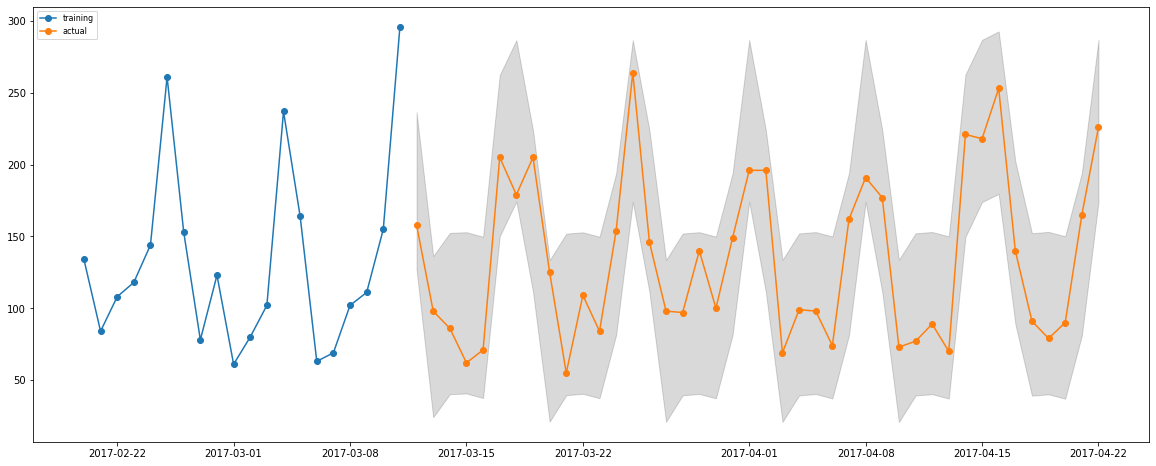

In [57]:
test[['lower', 'upper']] = results.get_forecast(steps=42, exog=exog_forecast).conf_int(alpha=0.05).values
test['pred'] = results.predict(steps=42, exog=exog_forecast).values[-42:]

plt.plot(train['total'][-20:], '-o', label='training')
plt.plot(test['total'], '-o', label='actual')
# plt.plot(test['pred'], '-o', label='prediction')
plt.fill_between(test.index, test['lower'], test['upper'], color='k', alpha=.15)
plt.legend(loc='upper left', fontsize=8)
plt.show()

---

# Prophet

- Easy to use library
- In build holiday feature
- Supports multiple seasonality - Weekly, monhtly, yearly
- In build CI
- Get a quick ouput - baseline
- Suuport exog


Cons:
- Not well meantained
- Painful to install
- Not enought things that you can change or control (few HP)
- Does not do well for certain time-series

These instructions work on Google Colab

```
pip install pystan~=2.14
pip install fbprophet
```

In [58]:
df = df1.copy()

In [60]:
# Required !!

df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['total']
df = df[['ds', 'y', 'holiday']]
df.head()

,ds,y,holiday
0,2016-01-01,296.0,1
1,2016-01-02,191.0,0
2,2016-01-03,202.0,0
3,2016-01-04,105.0,0
4,2016-01-05,98.0,0


In [63]:
from prophet import Prophet   # from fbprophet import Prophet

m = Prophet()
m.fit(df[['ds', 'y']][:-39])

future = m.make_future_dataframe(periods=39, freq="D")
forecast = m.predict(future)
forecast.head()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0756
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       852.818    0.00236155       98.0754           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       852.866   3.14326e-08        69.647      0.1894           1      186   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-01,143.021597,118.227695,195.568897,143.021597,143.021597,15.210069,15.210069,15.210069,15.210069,15.210069,15.210069,0.0,0.0,0.0,158.231666
1,2016-01-02,142.949814,194.319284,278.030910,142.949814,142.949814,94.486471,94.486471,94.486471,94.486471,94.486471,94.486471,0.0,0.0,0.0,237.436285
2,2016-01-03,142.878030,151.531445,229.990899,142.878030,142.878030,46.764581,46.764581,46.764581,46.764581,46.764581,46.764581,0.0,0.0,0.0,189.642611
3,2016-01-04,142.806246,56.964806,140.172511,142.806246,142.806246,-42.864620,-42.864620,-42.864620,-42.864620,-42.864620,-42.864620,0.0,0.0,0.0,99.941627
4,2016-01-05,142.734463,58.694146,141.014168,142.734463,142.734463,-39.700778,-39.700778,-39.700778,-39.700778,-39.700778,-39.700778,0.0,0.0,0.0,103.033685


In [74]:
performance(df['y'][:-39],forecast['yhat'][:-39])

MAE : 24.056
RMSE : 31.988
MAPE: 0.213


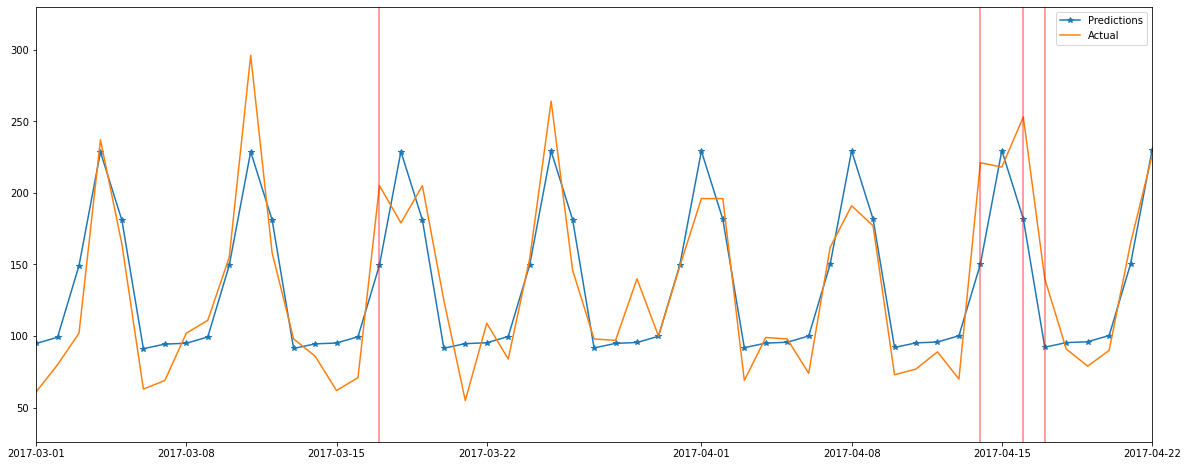

In [78]:
plt.plot(forecast['ds'], forecast['yhat'],'-*', label = 'Predictions')
plt.plot(df['ds'], df['y'], label = 'Actual')
for x in df.query('holiday==1')['ds']: 
    plt.axvline(x=x, color='red', alpha = 0.5);
plt.xlim(pd.to_datetime('2017-03-01'), pd.to_datetime('2017-04-22'))
plt.legend()

In [79]:
df.head()

,ds,y,holiday
0,2016-01-01,296.0,1
1,2016-01-02,191.0,0
2,2016-01-03,202.0,0
3,2016-01-04,105.0,0
4,2016-01-05,98.0,0


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.0756
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        958.77      0.004027        96.846           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       959.083   6.57355e-05       89.6605   5.811e-07       0.001      222  LS failed, Hessian reset 
     199       959.087   7.67341e-07       73.4156      0.5608      0.3445      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       959.296    0.00114553       126.475   8.588e-06       0.001      361  LS failed, Hessian reset 
     268        959.45   9.33301e-05       109.487   8.988e-07       0.001      450  LS failed, Hessian reset 
     299       959.472    1.9293e-07       98.8653      0.7668      0.7668      488   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

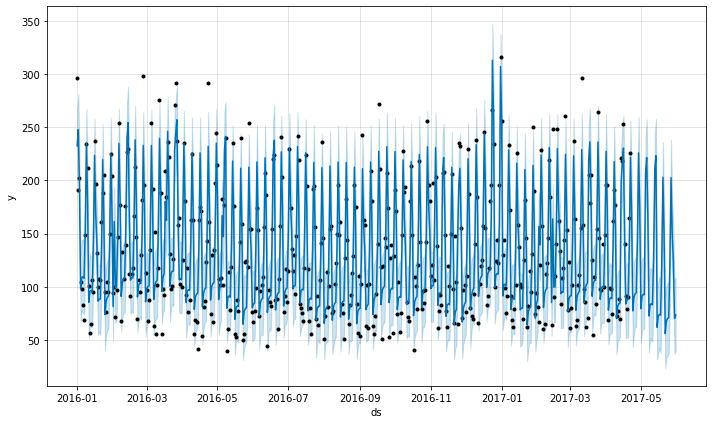

In [80]:
model2=Prophet(yearly_seasonality=True, weekly_seasonality=True)
model2.add_regressor('holiday') #adding holidays data in the model3
model2.fit(df[:-39])
forecast2 = model2.predict(df)
fig = model2.plot(forecast2)

In [81]:
performance(df['y'][:-39],forecast2['yhat'][:-39])

MAE : 19.99
RMSE : 25.75
MAPE: 0.181


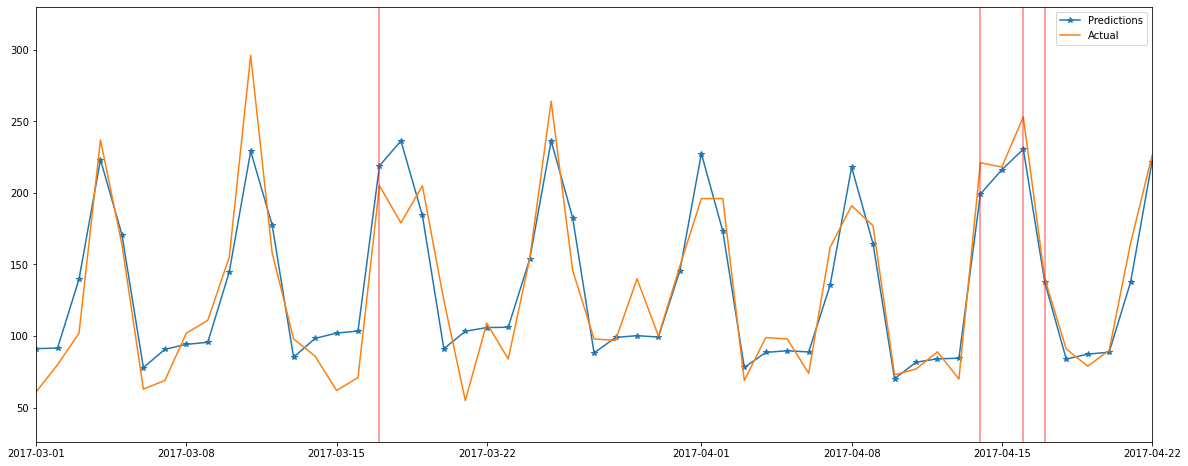

In [83]:
plt.plot(forecast2['ds'], forecast2['yhat'],'-*', label = 'Predictions')
plt.plot(df['ds'], df['y'], label = 'Actual')
for x in df.query('holiday==1')['ds']: 
    plt.axvline(x=x, color='red', alpha = 0.5);
plt.xlim(pd.to_datetime('2017-03-01'), pd.to_datetime('2017-04-22'))
plt.legend()

<AxesSubplot:ylabel='Density'>

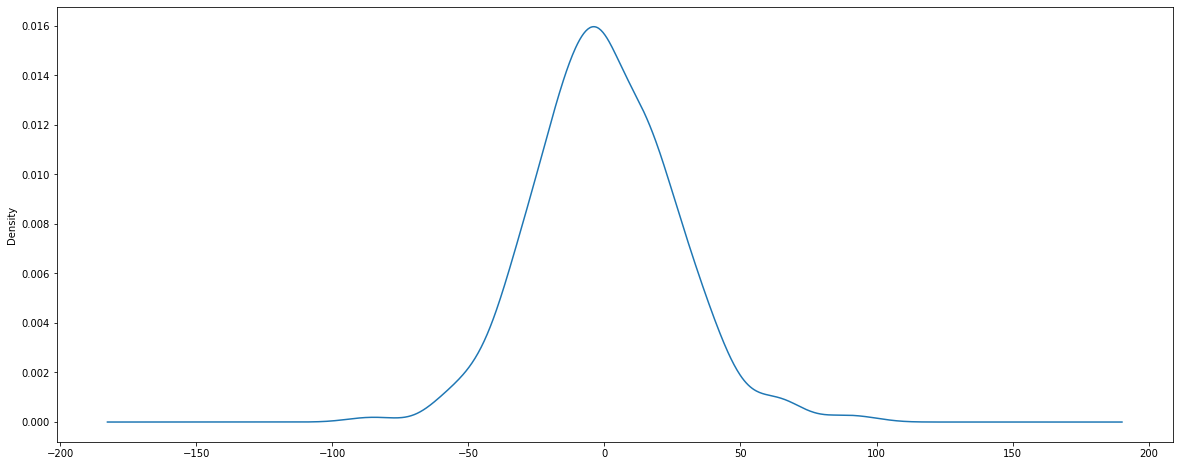

In [88]:
(df.y - forecast2.yhat).plot(kind='kde')

# Chagepoints